### General problem 

For a weight matrix $A$ sampled such that   

> $A_{ij} \sim N(\mu, \sigma^2) \quad \forall \quad i \ne j,$  

> $A_{ii} = -d \quad \forall \quad i = 1, ..., S$   

with $d > 0$, how does the largest eigenvalue of the community matrix   

> $ M_{ij} = \frac{\partial f_i}{\partial x_j} \Bigr|_{\mathbf{x}^*}$  

of some network with the dynamics 

> $ \dot{x}_i = f_i(\mathbf{x})$

behave? 

### Special case: Generalized Lotka-Volterra dynamics

> $\dot{x}_i = \alpha x_i + x_i \sum_{j} A_{ij} x_j$

with fixed point

> $x_i^* = - \alpha \sum_{k} {A^{-1}}_{ik}$,  

or put differently, $\mathbf{x^*} = - \alpha A^{-1} \cdot \mathbf{1}$, where $\mathbf{1} = (1, 1, ..., 1)^T$.

For the community matrix, one obtains 

> $ M_{ij} = - \alpha  A_{ij} \sum_{k} {A^{-1}}_{ik}$, 

i.e. some non-trivial combination of the random amtrix $A$ and the column sum of its inverse $A^{-1}$.  

In [1]:
from __future__ import print_function
import numpy as np
import scipy, theano
import time

% matplotlib inline 
import matplotlib.pyplot as plt
from imp import reload
import style as style; reload(style)
colors = style.colors

rng = np.random.RandomState(seed=0)

### Set parameters
# Number of nodes
n       = 500
# Mean and std. dev. of off-diagonal distribution
mu      = -1.
sigma   = 0.5
# Dynamical system: GLV
alpha   = 1.


In [2]:
def get_d_c(n, mu, sigma):
    # Calculate critical d
    if mu > 0:
        d_c = (n - 1) * mu
    else:
        d_c = np.sqrt(n * sigma**2) - mu
    return d_c

def get_A(
    n       = 100,
    mu      = -1.,
    sigma   = 0.5,
    density = 1.,
    d = 1.,
    ):
    """ Get weight matrix A.
    """
    ###  Sample weight matrix A
    # Off-diagonals taken from normal distr. 
    A = scipy.sparse.random(
            n, n,
            density      = density,
            dtype        = float,
            random_state = rng,
            data_rvs     = scipy.stats.norm(loc = mu, scale = sigma).rvs
            ).toarray()
    # Diagonals: constant -d
    np.fill_diagonal(A, -d)
    
    return A
    
def get_M(
    # Weight matrix
    A, 
    A_inv,
    alpha = 1.,):
    ### Calculate community matrix M
    return - alpha * np.einsum('ij, ik -> ij', A, A_inv)

def get_beta_and_x(A, x):
    A_sum       = np.sum(A)
    beta_eff    = np.einsum('ij, jk -> ', A, A) / A_sum
    x_eff       = np.einsum('ij, j -> ', A, x) / A_sum
    return beta_eff, x_eff


In [3]:
### Plot largest eigenvalue of M over varying d for constant A_{ij}

# Calculate relevant d
# d_c     = get_d_c(n, mu, sigma)
d_c     = get_d_c(n, mu, sigma) + 27
print("d_crit = %.3f"%d_c)
d_min = d_c * 0.7
d_max = d_c * 1.3
d_step = d_c * 0.05
ds = np.arange(d_min, d_max, d_step)

# Calculate eigenvals
m_loops = 10
max_eigvals = np.zeros((m_loops, len(ds)))
beta_effs   = np.zeros((m_loops, len(ds)))
x_effs      = np.zeros((m_loops, len(ds)))

# For different initializations of A
time0 = time.time()
for k in range(m_loops):
    A = get_A(n=500, mu=mu, sigma=sigma, d=0)
    for j, d in enumerate(ds):
        
        # Adapt diagonal
        np.fill_diagonal(A, -d)
        # Calculate inverse of A
        A_inv = np.linalg.inv(A)
        
        # Get community matrix and its eigvals
        M_d = get_M(A, A_inv, alpha=alpha)
        max_eigval_d        = scipy.sparse.linalg.eigs(M_d, k=1, which='LR', maxiter=None, tol=0, return_eigenvectors=False)
        max_eigvals[k, j]   = max_eigval_d.real
        
        # Calculate beta_eff, x_eff
        x_fix = - alpha * np.sum(A_inv, axis=1)
        beta_effs[k,j], x_effs[k, j]    = get_beta_and_x(A, x_fix)
        
print("Calculating eigvals took %.1f s"%(time.time() - time0))



d_crit = 39.180
Calculating eigvals took 56.2 s


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


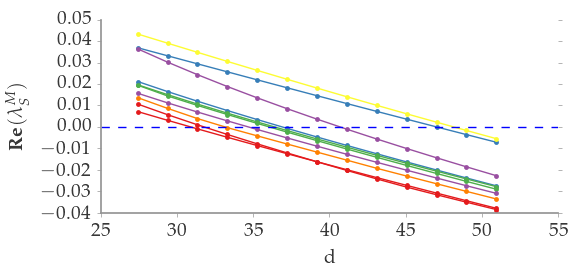

In [4]:
# Plotting
fig = plt.figure(figsize=(6, 3))
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

for k in range(m_loops):
    ax.plot(ds, max_eigvals[k], '.-')
ax.axhline(0, linestyle='--')

ax.set_xlabel("d")
ax.set_ylabel("$\mathbf{Re}(\lambda^M_S)$")
style.fixticks(fig)

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


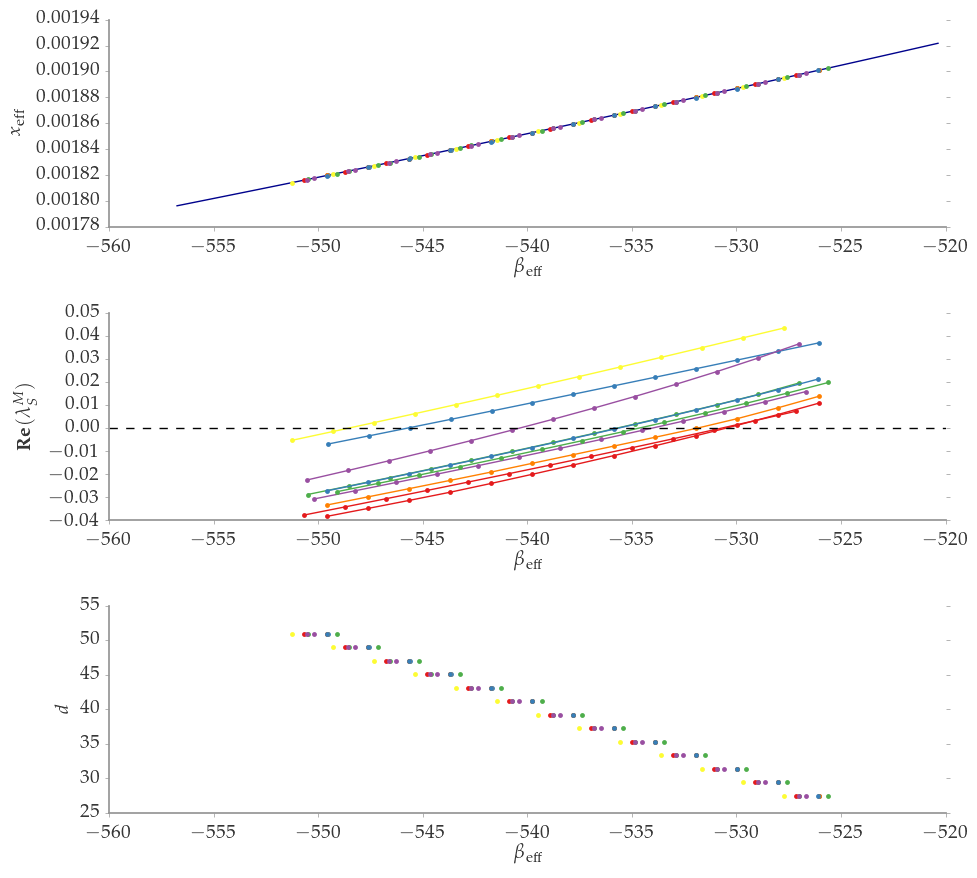

In [5]:
### Test the paper's hypothesis: 
#   Calculate the error over d as the system approaches non-stability from a far within stabiity.


# Theoretical x_eff(beta_eff)
x_of_beta   = lambda beta: -alpha / beta

beta_min    = np.min(beta_effs)
beta_max    = np.max(beta_effs)
betas       = np.linspace(beta_min*1.01, beta_max*0.99, 100)

# Plotting
fig = plt.figure(figsize=(10, 9))
ax0 = style.add_subplot(fig, n_rows_cols=(3, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
ax1 = style.add_subplot(fig, n_rows_cols=(3, 1), index_row_col=(1, 0), rowspan=1, colspan=1)
ax2 = style.add_subplot(fig, n_rows_cols=(3, 1), index_row_col=(2, 0), rowspan=1, colspan=1)

# Plot x_eff over beta_eff
ax0.plot(betas, x_of_beta(betas), c=colors[0], label='theory')
for k in range(m_loops):
    ax0.plot(beta_effs[k], x_effs[k], '.')
ax0.set_xlabel(r"$\beta_\mathrm{eff}$")
ax0.set_ylabel(r"$x_\mathrm{eff}$")

# Plot largest eigval lambda^M over beta_eff
for k in range(m_loops):
    ax1.plot(beta_effs[k], max_eigvals[k], '.-')
ax1.axhline(0, linestyle='--', c='k')
ax1.set_xlim(ax0.get_xlim())
ax1.set_xlabel(r"$\beta_\mathrm{eff}$")
ax1.set_ylabel(r"$\mathbf{Re}(\lambda^M_S)$")

# Plot d over beta_eff
for k in range(m_loops):
    ax2.plot(beta_effs[k], ds, '.')
ax2.set_xlim(ax0.get_xlim())
ax2.set_xlabel(r"$\beta_\mathrm{eff}$")
ax2.set_ylabel(r"$d$")

style.fixticks(fig)

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


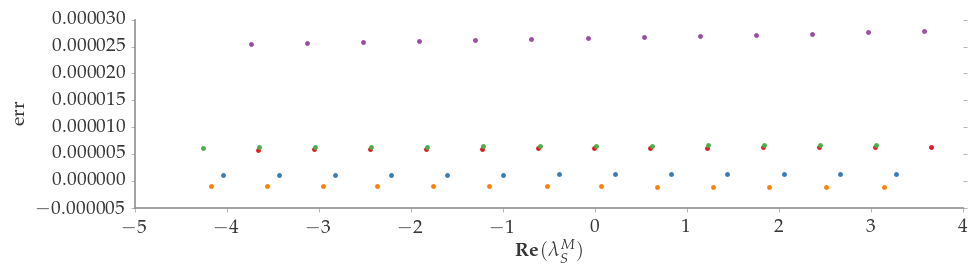

In [14]:
### Plot error

# Plotting
fig = plt.figure(figsize=(10, 3))
ax0 = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

err = 1 + alpha / (x_effs * beta_effs)

# Plot largest eigval lambda^M over beta_eff
for k in range(m_loops):
    ax0.plot(max_eigvals[k], err[k], '.')
ax0.set_xlabel(r"$\mathbf{Re}(\lambda^M_S)$")
ax0.set_ylabel(r"$\mathrm{err}$")

style.fixticks(fig)


# Some tests

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


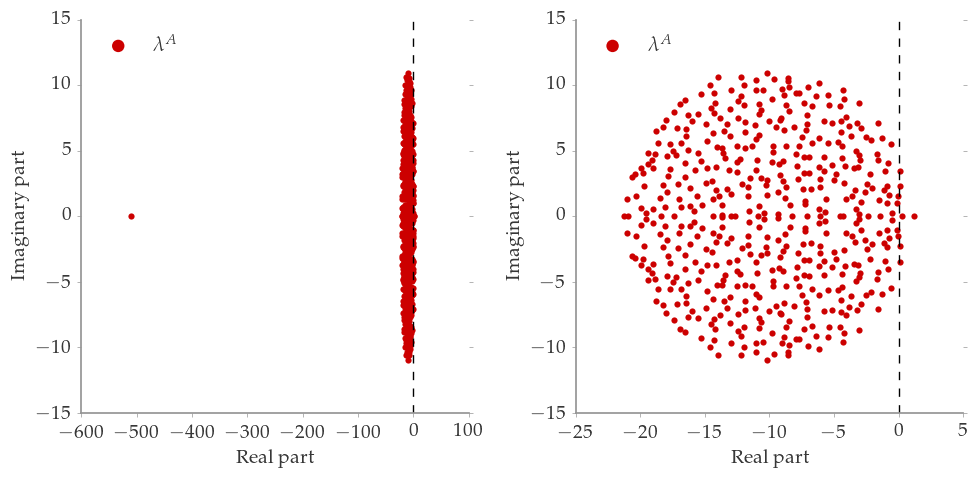

In [6]:
### Test: Plot spectrum of A:

d = get_d_c(n, mu, sigma) - 1

A = get_A(n=n, mu=mu, sigma=sigma, d=d)

eigvals_A = np.linalg.eigvals(A)

fig = plt.figure(figsize=(10, 5))
ax0 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax1 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

# with exceptional eigval
ax0.scatter(eigvals_A.real, eigvals_A.imag, marker='o', color=colors[1], linewidth=0.0, label='$\lambda^A$')

# without exceptional eigval
mask = eigvals_A.real > np.min(eigvals_A.real)
ax1.scatter(eigvals_A.real[mask], eigvals_A.imag[mask], marker='o', color=colors[1], linewidth=0.0, label='$\lambda^A$')

for ax in fig.axes:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    # max_xy = max(ax.get_ylim()[1], ax.get_xlim()[1])
    # min_xy = min(ax.get_ylim()[0], ax.get_xlim()[0])
    # ax.set_xlim((min_xy, max_xy))
    # ax.set_ylim((min_xy, max_xy))

    ax.legend(loc='best')

style.fixticks(fig)

d_crit = 12.180
Calculating eigvals took 47.3 s


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


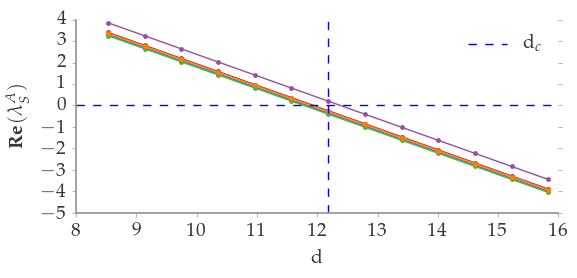

In [26]:
### Plot largest eigenvalue of A over varying d

# Calculate relevant d
# d_c     = get_d_c(n, mu, sigma)
d_c     = get_d_c(n, mu, sigma)
print("d_crit = %.3f"%d_c)
d_min = d_c * 0.7
d_max = d_c * 1.3
d_step = d_c * 0.05
ds = np.arange(d_min, d_max, d_step)

# Calculate eigenvals
m_loops = 5
max_eigvals = np.zeros((m_loops, len(ds)))

# For different initializations of A
time0 = time.time()
for k in range(m_loops):
    A = get_A(n=500, mu=mu, sigma=sigma, d=0)
    for j, d in enumerate(ds):
        # Adapt diagonal
        np.fill_diagonal(A, -d)
        # Get eigenvals
        max_eigval_d        = scipy.sparse.linalg.eigs(A, k=1, which='LR', maxiter=None, tol=0, return_eigenvectors=False)
        max_eigvals[k, j]   = max_eigval_d.real
        
print("Calculating eigvals took %.1f s"%(time.time() - time0))

# Plotting
fig = plt.figure(figsize=(6, 3))
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

for k in range(m_loops):
    ax.plot(ds, max_eigvals[k], '.-')
ax.axhline(0, linestyle='-', c='k')
ax.axvline(d_c, linestyle='--', label='d_c')
ax.legend(loc='best')

ax.set_xlabel("d")
ax.set_ylabel("$\mathbf{Re}(\lambda^A_S)$")
style.fixticks(fig)

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


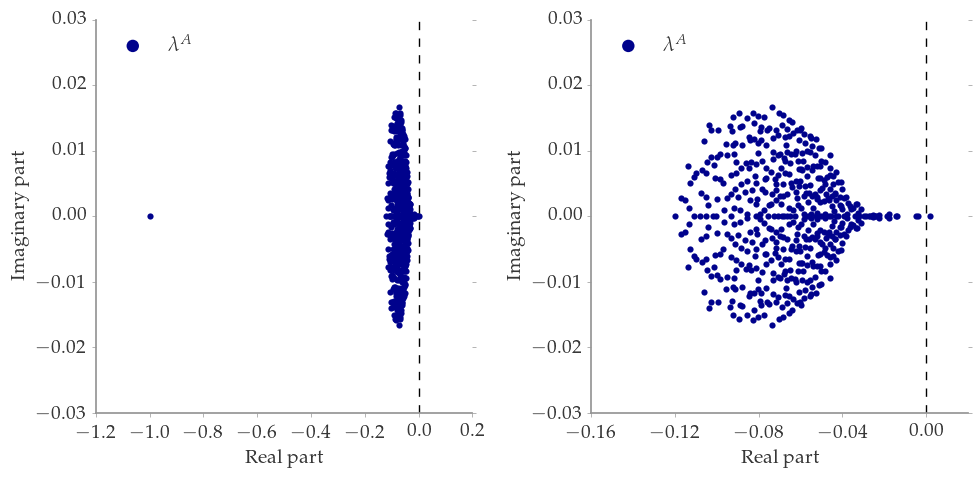

In [31]:
### Test: Plot spectrum of M:

d = get_d_c(n, mu, sigma) + 25

A   = get_A(n=n, mu=mu, sigma=sigma, d=d)
A_inv = np.linalg.inv(A)
M   = get_M(A, A_inv, alpha=alpha)
eigvals_M = np.linalg.eigvals(M)

fig = plt.figure(figsize=(10, 5))
ax0 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax1 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

# with exceptional eigval
ax0.scatter(eigvals_M.real, eigvals_M.imag, marker='o', color=colors[0], linewidth=0.0, label='$\lambda^A$')

# without exceptional eigval
mask = eigvals_M.real > np.min(eigvals_M.real)
ax1.scatter(eigvals_M.real[mask], eigvals_M.imag[mask], marker='o', color=colors[0], linewidth=0.0, label='$\lambda^A$')

for ax in fig.axes:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    # max_xy = max(ax.get_ylim()[1], ax.get_xlim()[1])
    # min_xy = min(ax.get_ylim()[0], ax.get_xlim()[0])
    # ax.set_xlim((min_xy, max_xy))
    # ax.set_ylim((min_xy, max_xy))

    ax.legend(loc='best')

ax1.set_xticks(ax1.get_xticks()[::2])

style.fixticks(fig)

In [28]:
### Testing 

# Do numpy and scipy agree finding the largest eigval?
lambda_max_np       = np.max(np.linalg.eigvals(M))
lambda_max_scipy    = scipy.sparse.linalg.eigs(M, k=1, which='LR', maxiter=None, tol=0, return_eigenvectors=False)
print(lambda_max_np, lambda_max_scipy)

# Test Timing
print("timeit numpy:")
%timeit np.linalg.eigvals(M)
print("timeit scipy:")
%timeit scipy.sparse.linalg.eigs(M, k=1, which='LR', maxiter=None, tol=0, return_eigenvectors=False)


(0.0091952835263+0j) [ 0.00919528+0.j]
timeit numpy:
1 loop, best of 3: 1.11 s per loop
timeit scipy:
10 loops, best of 3: 20.1 ms per loop


In [29]:
### Check fixed point
# Dynamical system: GLV
f = lambda x, A: alpha * x + x * np.dot(A, x)
# Fixed point
x_fix = - alpha * np.sum(A_inv, axis=1)
# Function at fixed point
print("f(x*) = %.3e; should be (very close to) zero."%np.sum(f(x_fix, A)))

f(x*) = 3.919e-17; should be (very close to) zero.
